# Introduction

In this presentation, performance of LSTM (Long Short-Term Memory neural network) in a specific task is compared with that of MLP (Multi-Layer Perceptron). However, MLP is trained on a data matrix where features are derived based on varying number of previous steps. Such feature engineering mimics ability to remember past information for an arbitrary number of time steps.

In particular, list of features that depend on non-constant number of previous steps includes:
* Maximal number of steps such that going them backwards from current time step results in monotonic changes of time series' value (being more rigorous, this feature is length of the longest interval from a set of intervals such that their right end is current time step and the time series is monotonic on them);
* Length of the longest interval from a set of intervals such that their right end is current time step and there exists exactly one point that possesses the following property: after its exclusion, the time series is monotonic on an interval without it;
* Length of the longest interval from a set of intervals such that their right end is current time step and each of them can be split into two intervals such that the time series is monotonic on both of these subintervals;
* Given split of the time series values into bins, number of steps between current step and the latest preceding step such that the value that is corresponding to it lies in the same bin as the current value.

Generally speaking, the task under consideration is forecasting with horizon that is bigger than one step. In other words, neural networks are trained to predict future values several steps ahead simultaneously, without passing predictions for previous future steps as ground truth. It is assumed that models should be trained to recognize temporal patterns in a sequence of observations, and prediction of future values based on external variables is beyond the scope of the presentation.

Time series that is used here is a real-world series with hourly frequency and strong intraday seasonality. Because aim of the presentation is to compare performance that is due to sequence modelling aspects of forecasting, nature of the series is not relevant here. Of course, involvement of domain-related features from appropriate external data can result in better accuracy of forecasting.

# General Preparations

### Import Statements and Random Seeds

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score

import tensorflow as tf

In [2]:
# This makes all graphs prettier.
import seaborn as sns
sns.set()

In [3]:
np.random.seed(361)
tf.set_random_seed(361)

### Data Extraction and Exploratory Analysis

In [4]:
ser = pd.read_csv('series_with_seasonality.csv')['value']
ser.head()

0    1.7024
1    0.3600
2    0.0000
3    0.0000
4    0.2848
Name: value, dtype: float64

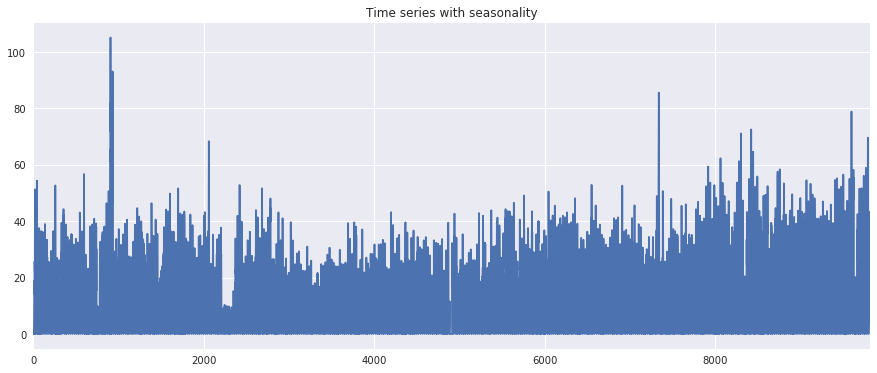

In [5]:
_ = ser.plot(figsize=(15, 6), title='Time series with seasonality')

It is hard to study the series behavior from the above graph, so look at small pieces of it.

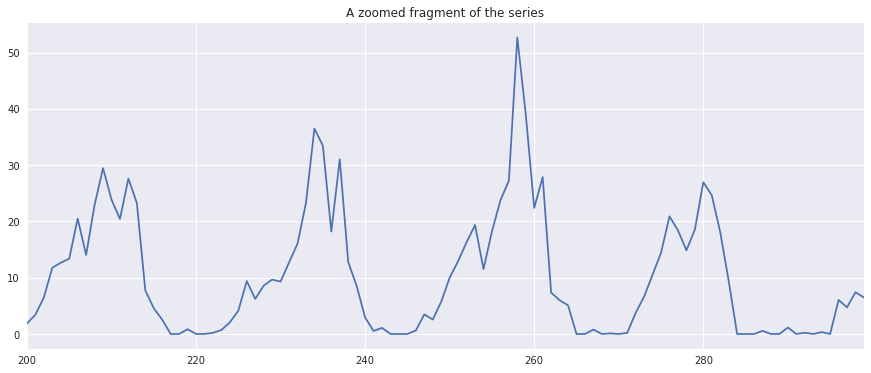

In [6]:
_ = ser[200:300].plot(figsize=(15, 6), title='A zoomed fragment of the series')

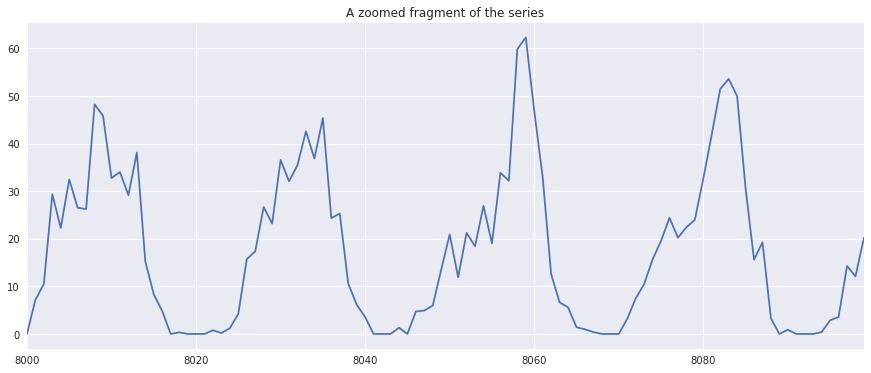

In [7]:
_ = ser[8000:8100].plot(figsize=(15, 6), title='A zoomed fragment of the series')

In [8]:
ser.describe()

count    9817.000000
mean       12.375714
std        12.806379
min         0.000000
25%         0.860800
50%         9.028800
75%        20.532800
max       105.168000
Name: value, dtype: float64

### Baseline Models

What forecast quality can be achieved by a simple baseline model such as, say, moving average of a specific window size?

Below MA(24) model is chosen, because 24 is period of seasonality of the series. One can try to use other window sizes — the higher they are, the more slowly predictions made for a long horizon converge to a constant.

In [9]:
window_size = 24
horizon = 100

Split data to a "train" set (actually, moving average has no fitting) and a hold-out test set. 

In [10]:
train_ratio = 0.75
train_test_frontier = int(round(train_ratio * len(ser.index), 0))

Now, evaluate performance of moving average both visually and numerically.

In [11]:
def plot_fact_vs_forecast(y_true, y_hat, position, horizon):
    """
    Visualizes `y_hat` against `y_true`
    for a time interval of length `horizon`
    that corresponds to `position`.

    @type y_true: pandas.Series
    @type y_hat: pandas.Series
    @type position: int
    @type horizon: int
    @rtype: NoneType
    """
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(
            position, position + horizon))
    ax.set_xticklabels([])

    y_true.plot(ax=ax, marker='o')
    pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

In [12]:
plot_every_n_steps = 1500

-0.10188688141676283

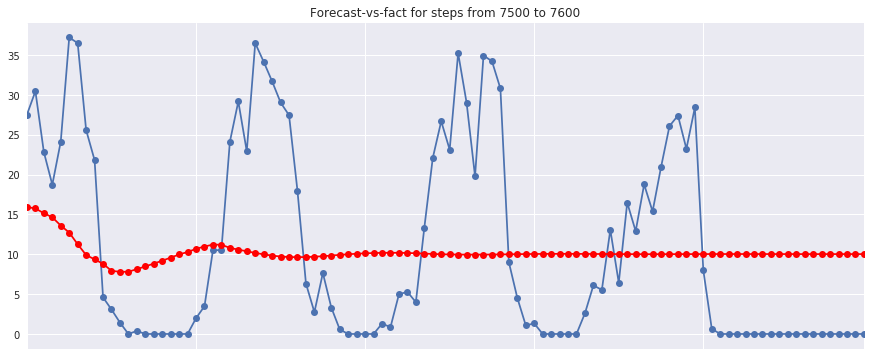

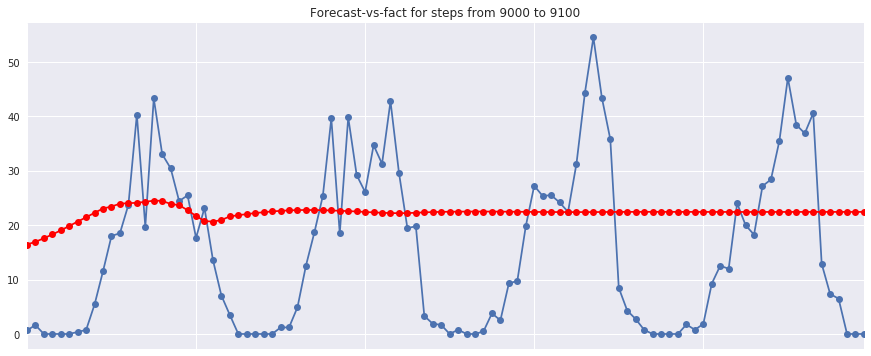

In [13]:
scores = []
for i in range(train_test_frontier, len(ser.index) - horizon):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - window_size):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-window_size:]) / window_size)

    y_hat = y_hat[window_size:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % plot_every_n_steps == 0:
        plot_fact_vs_forecast(y_true, y_hat, i, horizon)

sum(scores) / len(scores)

Of course, negative value of $R^2$ score is not a bug. To make a long story short, this means that actual values vary around corresponding predicted values more heavily than they vary around their mean. More detailed explanation is as follows. As it can be seen, MA(24) predictions converge quite rapidly to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

Moving average grasps trend better than seasonality, but the series under consideration has strong seasonality and no visible trend. Hence, it is appropriate to try another baseline method. What about simple fitting based on just aggregation over training set? Now, daily total sums are predicted as a constant estimated on the training set and then hourly predictions are obtained based on weights that are estimated on the training set too. These weigths represent intraday seasonality pattern.

In [14]:
period = 24

In [15]:
df = ser.to_frame(name='value')
df['hour'] = df.reset_index()['index'].apply(lambda x: x % period)
df.head()

,value,hour
0,1.7024,0
1,0.3600,1
2,0.0000,2
3,0.0000,3
4,0.2848,4


In [16]:
train_df = df.iloc[:(train_test_frontier - (train_test_frontier % period)), :]
level = train_df['value'].sum() / (len(train_df.index) / 24)
level

274.10338562091505

In [17]:
weights_df = train_df.groupby('hour').agg({'value': sum})
weights_df = (weights_df / weights_df['value'].sum()).reset_index()
weights_df.rename(columns={'value': 'weight'}, inplace=True)
weights_df

,hour,weight
0,0,0.008851
1,1,0.002189
2,2,0.001027
3,3,0.000458
4,4,0.000343
5,5,0.000503
6,6,0.003157
7,7,0.008700
8,8,0.013480
9,9,0.025812


In [18]:
df = df.reset_index().\
     merge(weights_df, on=['hour']).\
     sort_values(by='index').\
     set_index('index').\
     rename_axis(None)  # Delete name of index.
df['prediction'] = level * df['weight']
df.head()

,value,hour,weight,prediction
0,1.7024,0,0.008851,2.426008
1,0.3600,1,0.002189,0.599906
2,0.0000,2,0.001027,0.281610
3,0.0000,3,0.000458,0.125469
4,0.2848,4,0.000343,0.093956


Aggregation-based forecasting has horizon-independent results, so there is no need in rolling evaluation.

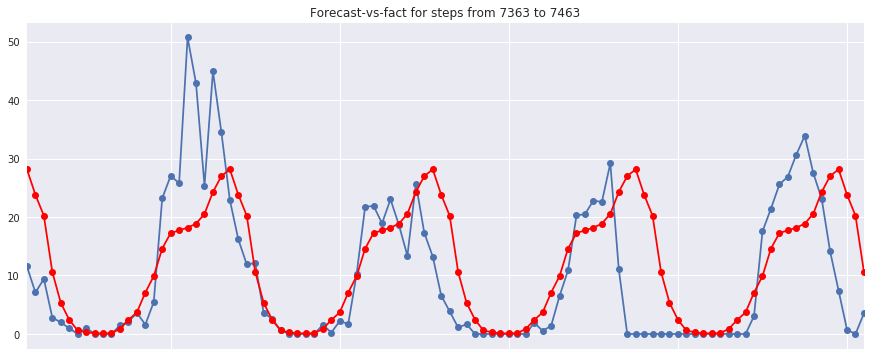

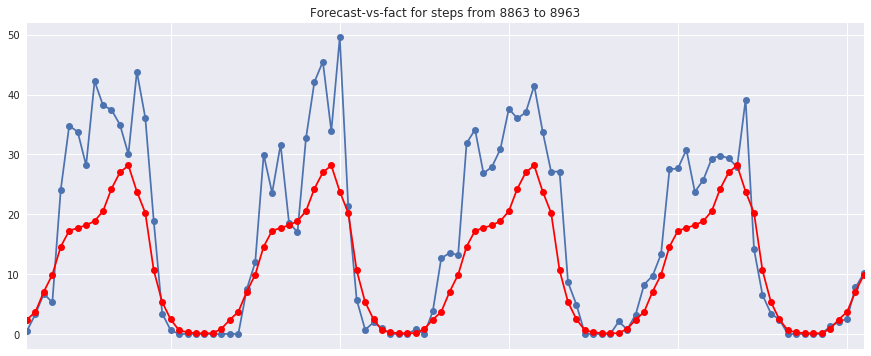

In [19]:
for i in range(train_test_frontier, len(ser.index) - horizon, plot_every_n_steps):
    y_true = df['value'].iloc[i:(i + horizon)]
    y_hat = df['prediction'].iloc[i:(i + horizon)]
    plot_fact_vs_forecast(y_true, y_hat, i, horizon)

In [20]:
test_df = df.iloc[train_test_frontier:, :]
r2_score(test_df['value'], test_df['prediction'])

0.64112578673776532

It is a decent score for such simple model, is not it?

An interested reader can try to use level that is predicted by moving average of daily total sums instead of constant level learnt from training data, but now it is the time to try neural networks.

# Template of Forecasting With Neural Networks

In [21]:
def take_ahead_and_lagged_values(ser, horizon, n_lags):
    """
    Converts `ser` to a data matrix
    with `horizon` ahead values and
    `n_lags` lagged values as well
    as a column for current value.
    
    @type ser: pandas.Series
    @type horizon: int
    @type n_lags: int
    @rtype: pandas.DataFrame
    """
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    return df

In [22]:
class AbstractRunner(object):
    """
    Combines and structurizes all utilities
    that evaluate neural networks' performances
    in the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features
    (also other features may be involved).
    """
    
    def __init__(self, horizon, n_lags):
        """
        @type horizon: int
        @type n_lags: int
        """
        self.horizon = horizon
        self.n_lags = n_lags
        
        self.sess = None
        
        self.graph = tf.Graph()
        self._define_placeholders()
            
    def _define_placeholders(self):
        """
        A virtual method.
        
        @rtype: NoneType
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")
        
    def _set_optimization_problem(self):
        """
        Defines optimization problem for training.
        This method must be called by `__init__` of
        child classes after neural network is built.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients in order to improve convergence.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
                                for grad, var in gradients]
            self.training_operation = optimizer.apply_gradients(capped_gradients)
            
    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        A virtual method.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")

    def _test(self, test_ser):
        """
        A virtual method.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")
        
    def _plot(self, true_series, forecasted_series, batch_cnt):
        """
        Visualizes `forecasted_series` against
        `true_series` for a time interval that
        corresponds to `batch_cnt`.
        
        @type true_series: numpy.ndarray
        @type forecasted_series: numpy.ndarray
        @type batch_cnt: int
        @rtype: NoneType
        """
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_xticklabels([])
        
        # TODO: Make `train_test_frontier` local variable. Now, it is global variable.
        start_step = train_test_frontier + batch_cnt
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(
            start_step, start_step + self.horizon))

        pd.Series(true_series).plot(ax=ax, marker='o')
        pd.Series(forecasted_series).plot(ax=ax, c='red', marker='o')
        
    def run(self, train_ser, test_ser, batch_size, n_epochs, learn_rate, keep_prob,
            ckpt_path=None):
        """
        Trains a model with a specified
        hyperparameters on `train_ser` and
        then evaluates its performance on
        `test_ser`.
        If `ckpt_path` is passed, the trained
        model is serialized as checkpoint
        files.
        
        @type train_ser: pandas.Series
        @type test_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: float
        """
        with tf.Session(graph=self.graph) as self.sess:
            self.sess.run(tf.global_variables_initializer())
            self._train(train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path)
            score = self._test(test_ser)
        return score

# Forecasting with LSTM

### Functions and Classes

In [23]:
def build_rnn(inputs, n_outputs, rnn_width, rnn_depth, keep_prob):
    """
    Defines architecture of an RNN.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type rnn_width: int
    @type rnn_depth: int
    @type keep_prob: tensorflow.Tensor
    @rtype: tuple(tensorflow.Tensor)
    """
    
    def get_basic_cell_with_dropout():
        """
        Just a utility for compatibility with
        Tensorflow v1.2.
        """
        basic_cell = tf.contrib.rnn.BasicLSTMCell(rnn_width)
        return tf.contrib.rnn.DropoutWrapper(basic_cell, keep_prob)

    multi_cell = tf.contrib.rnn.MultiRNNCell(
        [get_basic_cell_with_dropout() for _ in range(rnn_depth)])
    
    batch_size = tf.shape(inputs)[0]
    initial_state = tf.identity(multi_cell.zero_state(batch_size, tf.float32),
                                name='initial_state')
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(multi_cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name='final_state')
    
    preds = tf.contrib.layers.fully_connected(lstm_outputs, n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds, initial_state, final_state

In [24]:
def get_batches_for_lstm(ser, batch_size, horizon, n_lags):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @rtype: list(tuple(numpy.ndarray))
    """
    df = take_ahead_and_lagged_values(ser, horizon, n_lags)
    
    # Trim some old observations if they do not fit to `batch_size`.
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[-(n_batches*batch_size + horizon):-horizon, :]
    
    # Here, lagged features are treated as usual descriptive features.
    # Thus, objects have not any internal temporal structure.
    n_time_steps = 1

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [25]:
class RunnerOfLSTM(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate LSTM performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features.
    """
    
    def __init__(self, horizon, n_lags, rnn_width, rnn_depth):
        """
        @type horizon: int
        @type n_lags: int
        @type rnn_width: int
        @type rnn_depth: int
        """
        super().__init__(horizon, n_lags)
        self.rnn_width = rnn_width
        self.rnn_depth = rnn_depth
        
        self.state = None
        
        with self.graph.as_default():
            self.preds, self.initial_state, self.final_state = \
                build_rnn(self.inputs, self.horizon,
                          self.rnn_width, self.rnn_depth,
                          self.keep_prob)
        self._set_optimization_problem()
                
    def _define_placeholders(self):
        """
        Defines placeholders for input values,
        target values, and learning rate.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        Trains LSTM and informs about training.
        Also can save trained model and
        its last state if `ckpt_path` is set.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_lstm(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            # Reset state, because batches are started from the beginning of the series.
            state = self.sess.run(self.initial_state, {self.inputs: batches[0][0]})

            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.initial_state: state,
                             self.learning_rate: learn_rate,
                             self.keep_prob: keep_prob}
                y_hat, state, train_loss, _ = self.sess.run([self.preds,
                                                             self.final_state,
                                                             self.cost,
                                                             self.training_operation],
                                                            feed_dict)
            if epoch_cnt % 10 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        self.state = state
        if ckpt_path is not None:
            np.save(ckpt_path + '.state', self.state)
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batch_size = 1  # It is testing, not training.
        batches = get_batches_for_lstm(test_ser, batch_size, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            feed_dict = {self.inputs: x,
                         self.initial_state: self.state,
                         self.keep_prob: 1}
            y_hat, state = self.sess.run([self.preds, self.final_state],
                                         feed_dict)
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0][0], y_hat[0][0], batch_cnt)
        
        return sum(scores) / len(scores)

### Application

Here a massive LSTM is trained. To achieve test set $R^2$ coefficient of determination over 0.6, it is enough to have 24 lags and 100 epochs of training a network with hidden layers' width equal to 32.

In [26]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
rnn_width = 64
rnn_depth = 2

# Hyperparameters of training.
batch_size = 32
n_epochs = 300
learn_rate = 0.001
keep_prob = 0.8

Epoch   0:    train_loss = 439.471
Epoch  10:    train_loss = 373.438
Epoch  20:    train_loss = 295.006
Epoch  30:    train_loss = 258.314
Epoch  40:    train_loss = 252.282
Epoch  50:    train_loss = 253.296
Epoch  60:    train_loss = 255.073
Epoch  70:    train_loss = 257.089
Epoch  80:    train_loss = 259.738
Epoch  90:    train_loss = 252.868
Epoch 100:    train_loss = 257.606
Epoch 110:    train_loss = 258.264
Epoch 120:    train_loss = 255.918
Epoch 130:    train_loss = 255.244
Epoch 140:    train_loss = 261.462
Epoch 150:    train_loss = 256.294
Epoch 160:    train_loss = 254.319
Epoch 170:    train_loss = 260.375
Epoch 180:    train_loss = 261.047
Epoch 190:    train_loss = 260.561
Epoch 200:    train_loss = 257.032
Epoch 210:    train_loss = 256.823
Epoch 220:    train_loss = 258.931
Epoch 230:    train_loss = 257.585
Epoch 240:    train_loss = 256.879
Epoch 250:    train_loss = 258.918
Epoch 260:    train_loss = 257.001
Epoch 270:    train_loss = 255.844
Epoch 280:    train_

0.64023945873232802

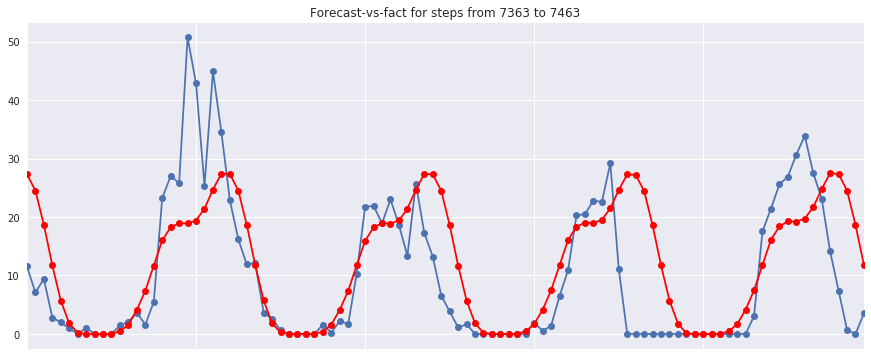

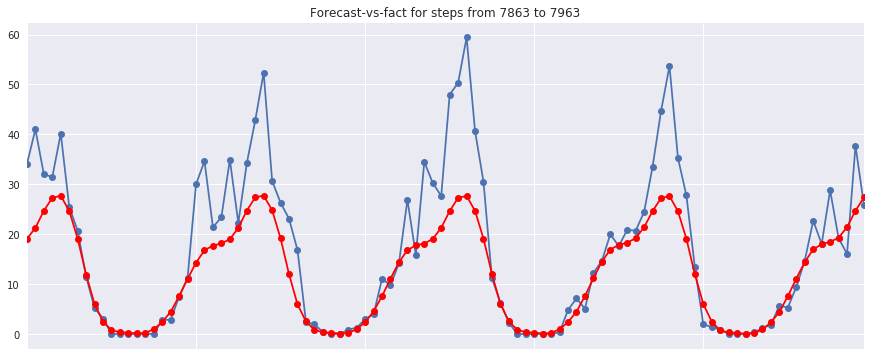

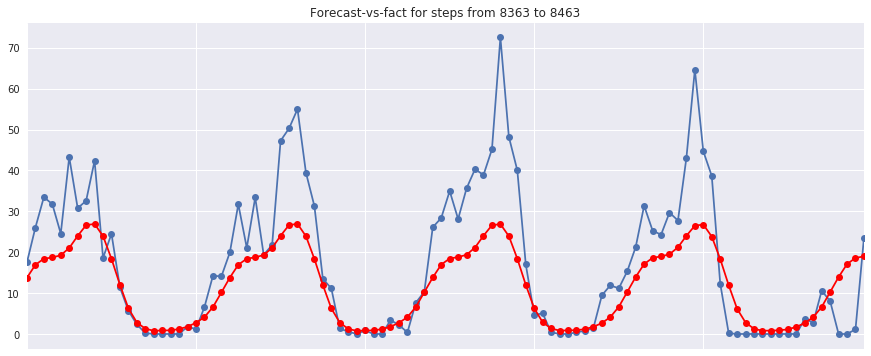

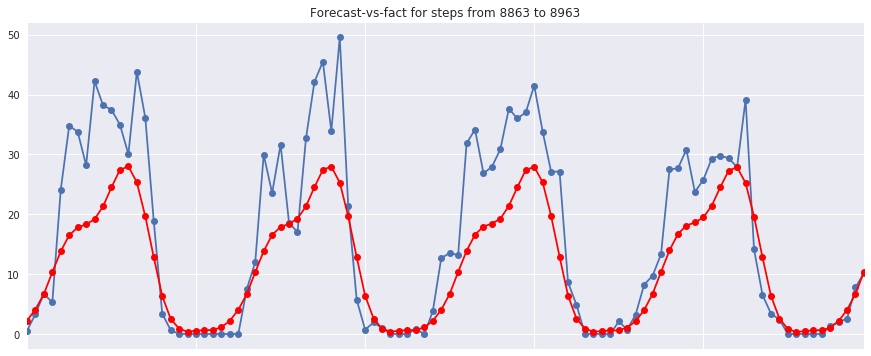

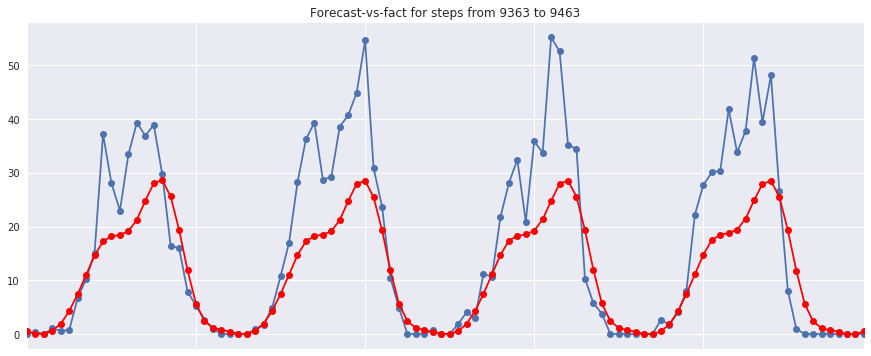

In [27]:
lstm_runner = RunnerOfLSTM(horizon, n_lags, rnn_width, rnn_depth)
# Training on `ser[:train_test_frontier + horizon]` involves test data.
score = lstm_runner.run(ser[:train_test_frontier],
                        # To have lag features and current value as a feature.
                        ser[train_test_frontier - n_lags - 1:],
                        batch_size, n_epochs, learn_rate, keep_prob,
                        ckpt_path='./trained_models/lstm.ckpt')
score

From one point of view, results are quite decent — $R^2$ is about two-thirds. Graphs evidence that LSTM has successfully learnt intraday seasonality pattern. From the other point of view, LSTM is on par with much more simpler benchmark model.

# Forecasting with MLP

### Functions and Classes

In [28]:
def build_mlp(inputs, n_outputs, hidden_layers_widths, keep_prob):
    """
    Defines architecture of an MLP.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type hidden_layers_widths: list(int)
    @type keep_prob: tensorflow.Tensor
    @rtype: tensorflow.Tensor
    """
    curr_layer = inputs
    for i in range(len(hidden_layers_widths)):
        curr_layer = tf.contrib.layers.fully_connected(
            curr_layer,
            hidden_layers_widths[i],
            weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
            biases_initializer=tf.truncated_normal_initializer(stddev=0.1))
        curr_layer = tf.layers.dropout(curr_layer, keep_prob)
    preds = tf.contrib.layers.fully_connected(
        curr_layer,
        n_outputs,
        activation_fn=None,  # To have gradients for negative predictions.
        weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
        biases_initializer=tf.truncated_normal_initializer(stddev=0.1))
    preds = tf.identity(preds, name='predictions')
    return preds

In [29]:
def get_batches_for_mlp(ser, batch_size, horizon, n_lags, mimic_lstm=False):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @type mimic_lstm: bool
    @rtype: list(tuple(numpy.ndarray))
    """
    df = take_ahead_and_lagged_values(ser, horizon, n_lags)
    
    # TODO: Engineer features described in the problem setup.
    if mimic_lstm:
        pass
    
    # Trim some old observations if they do not fit to `batch_size`.
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[-(n_batches*batch_size + horizon):-horizon, :]
    
    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, horizon))
    return list(zip(x_array, y_array))

In [30]:
class RunnerOfMLP(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate MLP performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values,
    a current value, and some aggregates
    as features.
    """

    def __init__(self, horizon, n_lags, hidden_layers_widths):
        """
        @type horizon: int
        @type n_lags: int
        @type hidden_layers_widths: int
        """
        super().__init__(horizon, n_lags)
        self.hidden_layers_widths = hidden_layers_widths
        
        with self.graph.as_default():
            self.preds = build_mlp(self.inputs, self.horizon,
                                   self.hidden_layers_widths, self.keep_prob)
        self._set_optimization_problem()

    def _define_placeholders(self):
        """
        Defines placeholders for input values,
        target values, learning rate, and
        probability to keep unit after dropout.
        
        @rtype: NoneType
        """
        with self.graph.as_default():
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, keep_prob, ckpt_path):
        """
        Trains MLP and informs about training.
        Also can save trained model
        if `ckpt_path` is set.

        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type keep_prob: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_mlp(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.learning_rate: learn_rate,
                             self.keep_prob: keep_prob}
                y_hat, train_loss, _ = self.sess.run([self.preds,
                                                      self.cost,
                                                      self.training_operation],
                                                     feed_dict)
            if epoch_cnt % 5 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        if ckpt_path is not None:
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.

        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batch_size = 1  # It is testing, not training.
        batches = get_batches_for_mlp(test_ser, batch_size, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            feed_dict = {self.inputs: x,
                         self.keep_prob: 1}
            y_hat = self.sess.run(self.preds, feed_dict)
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0], y_hat[0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0], y_hat[0], batch_cnt)

        return sum(scores) / len(scores)

### Application without Special Features

In [31]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
hidden_layers_widths = [10]

# Hyperparameters of training.
batch_size = 32
n_epochs = 30
learn_rate = 0.001
keep_prob = 0.8

Epoch   0:    train_loss = 274.608
Epoch   5:    train_loss = 273.420
Epoch  10:    train_loss = 273.340
Epoch  15:    train_loss = 273.190
Epoch  20:    train_loss = 272.615
Epoch  25:    train_loss = 271.277


0.74119500358209445

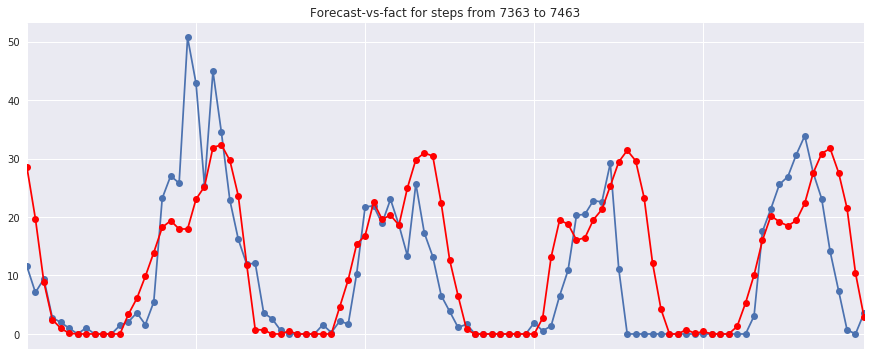

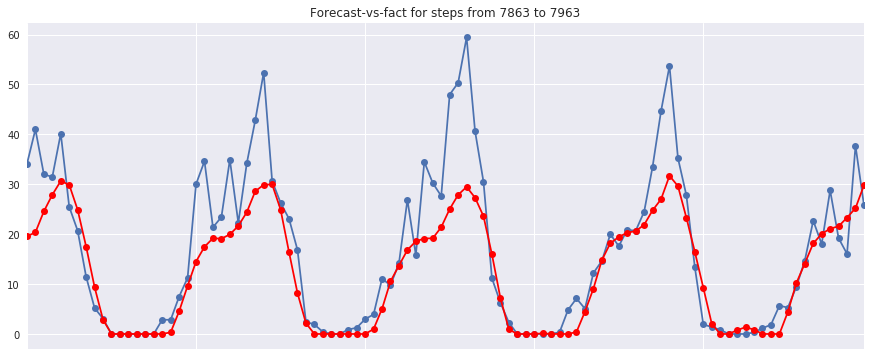

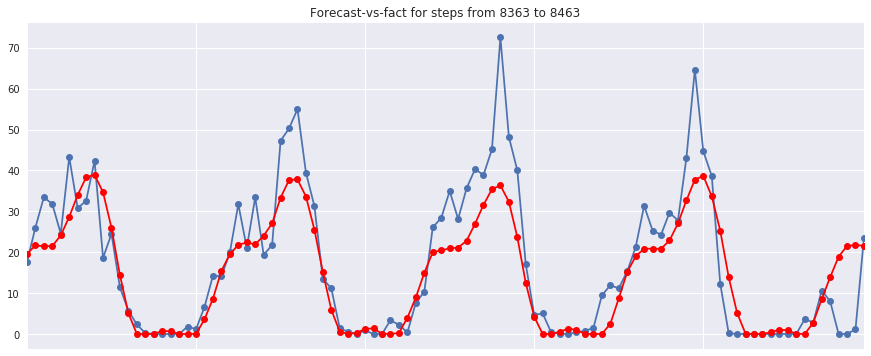

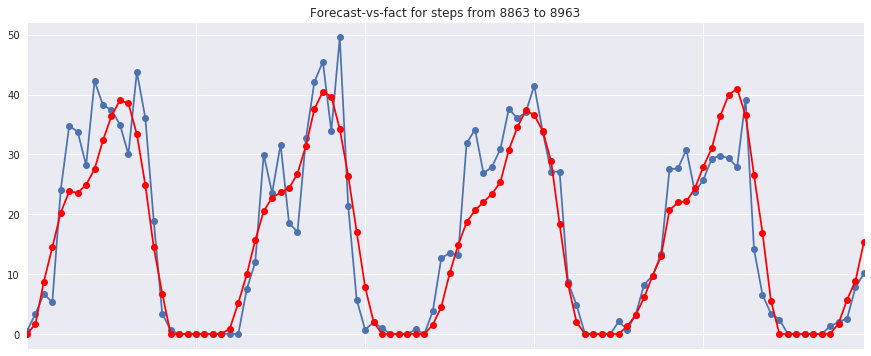

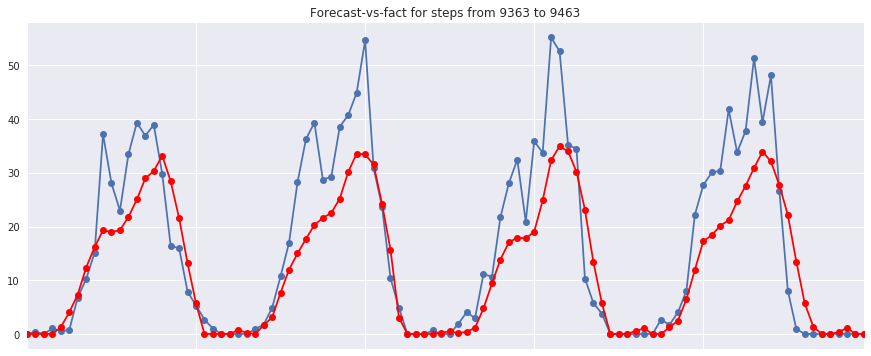

In [32]:
mlp_runner = RunnerOfMLP(horizon, n_lags, hidden_layers_widths)
score = mlp_runner.run(ser[:train_test_frontier],  # Not `ser[:train_test_frontier + horizon]`.
                       # To have lag features and current value as a feature.
                       ser[train_test_frontier - n_lags - 1:],
                       batch_size, n_epochs, learn_rate, keep_prob,
                       ckpt_path='./trained_models/mlp.ckpt')
score

The score is significantly higher than that of LSTM and training goes much faster.

### Application with Special Features

In [33]:
# TODO: Implement it.

# Conclusion

To be continued.